## Imports and settings

In [1]:
import src
import keras.backend as K

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from os import *
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

In [3]:
#forces CPU usage
environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
environ["CUDA_VISIBLE_DEVICES"] = "-1" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12514364863465302816
]


______________________________________-
## Data preprocessing

### Rain measurements
Measurements are downloaded from the DWD (German weather service) open data server: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/__<br>
I'm working with the data of August 2010 (based on [this](https://tradingeconomics.com/germany/precipitation)), so I have downloaded this: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/2010/RW-201008.tar__<br>
_DWD manual:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/BESCHREIBUNG_gridsgermany_hourly_radolan_historical_asc_de.pdf__<br><br>
This contains radar maps recorded in every hour. Each map has a resolution of $900\times900$ pixels and each pixel corresponds to an $1\,km\times1\,km$ area in reality. Pixel values are the precipitation height in $0.1\,mm$.
Below I'm importing the data of this as a series of numpy arrays and plot them to see the acual radar map. The _sys.path[0]_ is the path on my computer and it can be different for you.

In [60]:
train, xval, test = src.load_datasets("5min")

Training data: (6000, 2, 64, 64, 1)
Validation data: (2000, 2, 64, 64, 1)
Test data: (2000, 2, 64, 64, 1)


In [61]:
unet_train     = np.reshape(train[:,0,:,:,:],((train.shape[0],)+train.shape[2:]))
unet_truth     = np.reshape(train[:,1,:,:,:],((train.shape[0],)+train.shape[2:]))
unet_val       = np.reshape(xval[:,0,:,:,:],((xval.shape[0],)+xval.shape[2:]))
unet_val_truth = np.reshape(xval[:,1,:,:,:],((xval.shape[0],)+xval.shape[2:]))
print(unet_train.shape,"\n",unet_truth.shape,"\n",unet_val.shape,"\n",unet_truth.shape)
unet_test      = np.reshape(test[:,0,:,:,:],((test.shape[0],)+test.shape[2:]))
unet_test_truth = np.reshape(test[:,1,:,:,:],((test.shape[0],)+test.shape[2:]))

(6000, 64, 64, 1) 
 (6000, 64, 64, 1) 
 (2000, 64, 64, 1) 
 (6000, 64, 64, 1)


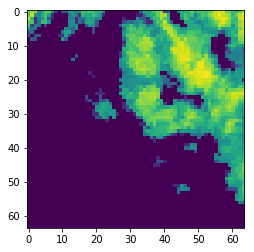

In [64]:
plt.imshow(unet_test[0,:,:,0])

In [ ]:
overfit_train = np.reshape(train[5,0,:,:,:],((1,)+train.shape[2:]))
overfit_truth = np.reshape(train[5,1,:,:,:],((1,)+train.shape[2:]))

In [ ]:
%matplotlib inline
src.visualise_data(xval[:,:,:,:,0])

## U-net

In [11]:
#model2=keras.Sequential()
def unet():
    init       = keras.layers.Input(shape=(64,64,1))
    ConvDown1  = keras.layers.Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding="same")(init)
    Lr1        = keras.layers.LeakyReLU(alpha=0.0)(ConvDown1)
    #64
    ConvDown2  = keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2),padding="same")(Lr1)
    Lr2        = keras.layers.LeakyReLU(alpha=0.0)(ConvDown2)
    #32
    ConvDown3  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr2)
    Lr3        = keras.layers.LeakyReLU(alpha=0.0)(ConvDown3)
    #16
    ConvDown4  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr3)
    Lr4        = keras.layers.LeakyReLU(alpha=0.0)(ConvDown4)
    #8
    ConvDown5  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr4)
    Lr5        = keras.layers.LeakyReLU(alpha=0.0)(ConvDown5)
    #4

    UpSamp1 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr5)
    #8
    merge1  = keras.layers.concatenate([ConvDown4,UpSamp1],axis=-1)#(UpSamp1)
    Conv1   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge1)
    Lr6     = keras.layers.LeakyReLU(alpha=0.0)(Conv1)
    #8
    UpSamp2 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr6)
    #16
    merge2  = keras.layers.concatenate([ConvDown3,UpSamp2],axis=-1)#(UpSamp2)
    Conv2   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge2)
    Lr7     = keras.layers.LeakyReLU(alpha=0.0)(Conv2)
    #16
    UpSamp3 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr7)

    #32
    Conv3   = keras.layers.Conv2D(filters=16,kernel_size=(4,4),strides=(1,1),padding="same")(UpSamp3)
    Lr8     = keras.layers.LeakyReLU(alpha=0.0)(Conv3)

    UpSamp4 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr8)
    #64
    Conv4   = keras.layers.Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'relu')(UpSamp4)

    Conv5   = keras.layers.Conv2D(filters=1,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'elu')(Conv4)
    
    return keras.models.Model(inputs=init, outputs=Conv5)

Discriminator

In [14]:
#Ds = keras.Sequential()
def spatial_discriminator():
    dropout = 0.5
    init = keras.layers.Input(shape=(64,64,1))
    
    conv1 = keras.layers.Conv2D(filters=4 ,kernel_size=4, strides=2, padding='same')(init)
    relu1 = keras.layers.LeakyReLU(alpha=0.2)(conv1)
    dropout1 = keras.layers.Dropout(dropout)(relu1)
    
    conv2 = keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same')(dropout1)
    relu2 = keras.layers.LeakyReLU(alpha=0.2)(conv2)
    dropout2 = keras.layers.Dropout(dropout)(relu2)
    
    conv3 = keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same')(dropout2)
    relu3 = keras.layers.LeakyReLU(alpha=0.2)(conv3)
    dropout3 = keras.layers.Dropout(dropout)(relu3)
    
    conv4 = keras.layers.Conv2D(filters=32, kernel_size=4, strides=2, padding='same')(dropout3)
    relu4 = keras.layers.LeakyReLU(alpha=0.2)(conv4)
    dropout4 = keras.layers.Dropout(dropout)(relu4)
    
    # Out: 1-dim probability
    flatten = keras.layers.Flatten()(dropout4)
    fcl1 = keras.layers.Dense(1)(flatten)
    sig1 = keras.layers.Activation('sigmoid')(fcl1)
    
    return keras.models.Model(inputs=init, outputs=sig1)

In [93]:
def temporal_discriminator():
    dropout = 0.5
    init = keras.layers.Input(shape=(2,64,64,3)) # t - 1, t
    advected = np.array(advect(init[0]),init[1])
    
    conv1 = keras.layers.Conv2D(filters=4 ,kernel_size=4, strides=2, padding='same')(advected)
    relu1 = keras.layers.LeakyReLU(alpha=0.2)(conv1)
    dropout1 = keras.layers.Dropout(dropout)(relu1)
    
    conv2 = keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same')(dropout1)
    relu2 = keras.layers.LeakyReLU(alpha=0.2)(conv2)
    dropout2 = keras.layers.Dropout(dropout)(relu2)
    
    conv3 = keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same')(dropout2)
    relu3 = keras.layers.LeakyReLU(alpha=0.2)(conv3)
    dropout3 = keras.layers.Dropout(dropout)(relu3)
    
    conv4 = keras.layers.Conv2D(filters=32, kernel_size=4, strides=2, padding='same')(dropout3)
    relu4 = keras.layers.LeakyReLU(alpha=0.2)(conv4)
    dropout4 = keras.layers.Dropout(dropout)(relu4)
    
    # Out: 1-dim probability
    flatten = keras.layers.Flatten()(dropout4)
    fcl1 = keras.layers.Dense(1)(flatten)
    sig1 = keras.layers.Activation('sigmoid')(fcl1)
    
    return keras.models.Model(inputs=init, outputs=sig1)

In [53]:
def advect(image): # (64,64,3)
    padded = np.pad(image,(0,1),'edge')[:,:,:-1]
    advected = np.empty_like(image)
    advected[:,:,0] = image[:,:,0] + image[:,:,1]*(padded[1:,:,0] - padded[:-1,:,0])[:,:-1] + image[:,:,2]*(padded[:,1:,0] - padded[:,:-1,0])[:-1]
    advected[:,:,1:] = image[:,:,1:]
    return advected

In [51]:
#modified from source: https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
class GAN():
    def __init__(self):
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.metric = [src.relative_error_tensor]

        optimizer = keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=self.metric)

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        input_img = keras.layers.Input(shape=self.img_shape)
        generated = self.generator(input_img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = keras.models.Model(input_img, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self,network="U-net"):  
        generator = keras.Sequential()
        if network in ["Unet", "U-net", "unet", "u-net"]:
            return unet()

    def build_discriminator(self):
        return spatial_discriminator()

    def train(self, epochs, dataset="5min", batch_size=128):

        # Load the dataset
        train, xval, test = load_datasets()
        unet_train     = np.reshape(train[:,0,:,:,:],((train.shape[0],)+train.shape[2:]))
        unet_truth     = np.reshape(train[:,1,:,:,:],((train.shape[0],)+train.shape[2:]))
        unet_val       = np.reshape(xval[:,0,:,:,:],((xval.shape[0],)+xval.shape[2:]))
        unet_val_truth = np.reshape(xval[:,1,:,:,:],((xval.shape[0],)+xval.shape[2:]))
        print(unet_train.shape,"\n",unet_truth.shape,"\n",unet_val.shape,"\n",unet_truth.shape)
        unet_test      = np.reshape(test[:,0,:,:,:],((test.shape[0],)+test.shape[2:]))
        unet_test_truth = np.reshape(test[:,1,:,:,:],((test.shape[0],)+test.shape[2:]))
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, unet_truth.shape[0], batch_size)
            real_imgs = unet_truth[idx]
            idx2 = np.random.randint(0, unet_train.shape[0], batch_size)
            training_batch = unet_train[idx2]

            # Generate a batch of new images
            generated_imgs = self.generator.predict(training_batch)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(generated_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            idx3 = np.random.randint(0, unet_train.shape[0], batch_size)
            training_batch = unet_train[idx3]

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(training_batch, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch in [int(x) for x in np.linspace(0.1,1,10)*epochs]:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        n = 5
        test_batch = unet_test[:n]
        test_truth = unet_test_truth[:n]
        gen_imgs = self.generator.predict(test_batch)

        fig, axs = plt.subplots(n, 3, figsize=(16, 16))
        for i in range(n):
                axs[i,0].imshow(test_batch[i, :,:,0])
                axs[i,0].axis('off')
                axs[i,0].set_title("Frame t")
                axs[i,1].imshow(test_truth[i, :,:,0])
                axs[i,1].axis('off')
                axs[i,1].set_title("Frame t+1")
                axs[i,2].imshow(gen_imgs[i, :,:,0])
                axs[i,2].axis('off')
                axs[i,2].set_title("Prediction t+1")
        fig.savefig("Plots/epoch %d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=1000, batch_size=64)

Tensor("metrics_18/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("activation_12_target:0", shape=(?, ?), dtype=float32)
Training data: (6000, 2, 64, 64, 1)
Validation data: (2000, 2, 64, 64, 1)
Test data: (2000, 2, 64, 64, 1)
(6000, 64, 64, 1) 
 (6000, 64, 64, 1) 
 (2000, 64, 64, 1) 
 (6000, 64, 64, 1)
0 [D loss: 0.694382, acc.: inf%] [G loss: 0.692332]
1 [D loss: 0.671125, acc.: inf%] [G loss: 0.692348]
2 [D loss: 0.643318, acc.: inf%] [G loss: 0.691957]
3 [D loss: 0.656173, acc.: inf%] [G loss: 0.691569]
4 [D loss: 0.652376, acc.: inf%] [G loss: 0.687972]
5 [D loss: 0.622827, acc.: inf%] [G loss: 0.685542]
6 [D loss: 0.622107, acc.: inf%] [G loss: 0.674893]
7 [D loss: 0.619547, acc.: inf%] [G loss: 0.659973]
8 [D loss: 0.609278, acc.: inf%] [G loss: 0.630330]
9 [D loss: 0.631199, acc.: inf%] [G loss: 0.599790]
10 [D loss: 0.688986, acc.: inf%] [G loss: 0.544193]
11 [D loss: 0.727410, acc.: inf%] [G loss: 0.472548]
12 [D loss: 0.867030, acc.: inf%] [G loss: 0.44327

21 [D loss: 0.667778, acc.: inf%] [G loss: 0.772905]
22 [D loss: 0.706351, acc.: inf%] [G loss: 0.733046]
23 [D loss: 0.724927, acc.: inf%] [G loss: 0.725250]
24 [D loss: 0.691642, acc.: inf%] [G loss: 0.702575]
25 [D loss: 0.675188, acc.: inf%] [G loss: 0.699554]
26 [D loss: 0.716073, acc.: inf%] [G loss: 0.697170]
27 [D loss: 0.701930, acc.: inf%] [G loss: 0.692693]
28 [D loss: 0.674637, acc.: inf%] [G loss: 0.692813]
29 [D loss: 0.677791, acc.: inf%] [G loss: 0.690514]
30 [D loss: 0.661144, acc.: inf%] [G loss: 0.690959]
31 [D loss: 0.684675, acc.: inf%] [G loss: 0.689566]
32 [D loss: 0.680864, acc.: inf%] [G loss: 0.689188]
33 [D loss: 0.668741, acc.: inf%] [G loss: 0.688498]
34 [D loss: 0.660797, acc.: inf%] [G loss: 0.686428]
35 [D loss: 0.671190, acc.: inf%] [G loss: 0.686152]
36 [D loss: 0.634855, acc.: inf%] [G loss: 0.684791]
37 [D loss: 0.664626, acc.: inf%] [G loss: 0.681105]
38 [D loss: 0.658749, acc.: inf%] [G loss: 0.673045]
39 [D loss: 0.658493, acc.: inf%] [G loss: 0.6

43 [D loss: 0.861830, acc.: inf%] [G loss: 0.537158]
44 [D loss: 0.834534, acc.: inf%] [G loss: 0.567343]
45 [D loss: 0.811218, acc.: inf%] [G loss: 0.767736]
46 [D loss: 0.716222, acc.: inf%] [G loss: 0.749249]
47 [D loss: 0.743900, acc.: inf%] [G loss: 0.994874]
48 [D loss: 0.673128, acc.: inf%] [G loss: 0.797843]
49 [D loss: 0.707662, acc.: inf%] [G loss: 0.764643]
50 [D loss: 0.684262, acc.: inf%] [G loss: 0.758697]
51 [D loss: 0.702777, acc.: inf%] [G loss: 0.737116]
52 [D loss: 0.699242, acc.: inf%] [G loss: 0.721692]
53 [D loss: 0.677170, acc.: inf%] [G loss: 0.704583]
54 [D loss: 0.694463, acc.: inf%] [G loss: 0.700524]
55 [D loss: 0.694609, acc.: inf%] [G loss: 0.701437]
56 [D loss: 0.677634, acc.: inf%] [G loss: 0.704238]
57 [D loss: 0.703574, acc.: inf%] [G loss: 0.698121]
58 [D loss: 0.690280, acc.: inf%] [G loss: 0.692418]
59 [D loss: 0.691311, acc.: inf%] [G loss: 0.692684]
60 [D loss: 0.681572, acc.: inf%] [G loss: 0.687662]
61 [D loss: 0.683107, acc.: inf%] [G loss: 0.6

65 [D loss: 0.677824, acc.: inf%] [G loss: 0.668886]
66 [D loss: 0.681535, acc.: inf%] [G loss: 0.664875]
67 [D loss: 0.686957, acc.: inf%] [G loss: 0.671597]
68 [D loss: 0.679243, acc.: inf%] [G loss: 0.652218]
69 [D loss: 0.690410, acc.: inf%] [G loss: 0.657610]
70 [D loss: 0.698854, acc.: inf%] [G loss: 0.644627]
71 [D loss: 0.706975, acc.: inf%] [G loss: 0.636048]
72 [D loss: 0.723691, acc.: inf%] [G loss: 0.628758]
73 [D loss: 0.717600, acc.: inf%] [G loss: 0.652756]
74 [D loss: 0.706294, acc.: inf%] [G loss: 0.704414]
75 [D loss: 0.705364, acc.: inf%] [G loss: 0.692185]
76 [D loss: 0.708413, acc.: inf%] [G loss: 0.715905]
77 [D loss: 0.723726, acc.: inf%] [G loss: 0.711348]
78 [D loss: 0.697851, acc.: inf%] [G loss: 0.706683]
79 [D loss: 0.679653, acc.: inf%] [G loss: 0.695426]
80 [D loss: 0.700202, acc.: inf%] [G loss: 0.697087]
81 [D loss: 0.675280, acc.: inf%] [G loss: 0.686625]
82 [D loss: 0.692090, acc.: inf%] [G loss: 0.675422]
83 [D loss: 0.696766, acc.: inf%] [G loss: 0.6

87 [D loss: 0.699078, acc.: inf%] [G loss: 0.648502]
88 [D loss: 0.698319, acc.: inf%] [G loss: 0.661803]
89 [D loss: 0.709087, acc.: inf%] [G loss: 0.687368]
90 [D loss: 0.683546, acc.: inf%] [G loss: 0.657966]
91 [D loss: 0.707153, acc.: inf%] [G loss: 0.658589]
92 [D loss: 0.685831, acc.: inf%] [G loss: 0.673315]
93 [D loss: 0.698665, acc.: inf%] [G loss: 0.665856]
94 [D loss: 0.684583, acc.: inf%] [G loss: 0.660269]
95 [D loss: 0.686125, acc.: inf%] [G loss: 0.685887]
96 [D loss: 0.675628, acc.: inf%] [G loss: 0.689996]
97 [D loss: 0.667622, acc.: inf%] [G loss: 0.692075]
98 [D loss: 0.671627, acc.: inf%] [G loss: 0.676044]
99 [D loss: 0.676533, acc.: inf%] [G loss: 0.673420]
100 [D loss: 0.672509, acc.: inf%] [G loss: 0.695479]
101 [D loss: 0.674269, acc.: inf%] [G loss: 0.647818]
102 [D loss: 0.700917, acc.: inf%] [G loss: 0.631209]
103 [D loss: 0.739397, acc.: inf%] [G loss: 0.663601]
104 [D loss: 0.742978, acc.: inf%] [G loss: 0.647797]
105 [D loss: 0.729181, acc.: inf%] [G los

109 [D loss: 0.711562, acc.: inf%] [G loss: 0.675014]
110 [D loss: 0.708778, acc.: inf%] [G loss: 0.678964]
111 [D loss: 0.699619, acc.: inf%] [G loss: 0.668948]
112 [D loss: 0.711071, acc.: inf%] [G loss: 0.654871]
113 [D loss: 0.711655, acc.: inf%] [G loss: 0.659589]
114 [D loss: 0.699697, acc.: inf%] [G loss: 0.643069]
115 [D loss: 0.715980, acc.: inf%] [G loss: 0.637690]
116 [D loss: 0.710093, acc.: inf%] [G loss: 0.633683]
117 [D loss: 0.698329, acc.: inf%] [G loss: 0.632957]
118 [D loss: 0.686002, acc.: inf%] [G loss: 0.657964]
119 [D loss: 0.720232, acc.: inf%] [G loss: 0.636876]
120 [D loss: 0.690254, acc.: inf%] [G loss: 0.675827]
121 [D loss: 0.684035, acc.: inf%] [G loss: 0.668644]
122 [D loss: 0.677195, acc.: inf%] [G loss: 0.669286]
123 [D loss: 0.668159, acc.: inf%] [G loss: 0.672976]
124 [D loss: 0.671349, acc.: inf%] [G loss: 0.685207]
125 [D loss: 0.665257, acc.: inf%] [G loss: 0.686377]
126 [D loss: 0.650318, acc.: inf%] [G loss: 0.693342]
127 [D loss: 0.636989, acc.:

131 [D loss: 0.593875, acc.: inf%] [G loss: 0.740223]
132 [D loss: 0.595873, acc.: inf%] [G loss: 0.755495]
133 [D loss: 0.565173, acc.: inf%] [G loss: 0.753891]
134 [D loss: 0.548588, acc.: inf%] [G loss: 0.761947]
135 [D loss: 0.524917, acc.: inf%] [G loss: 0.801683]
136 [D loss: 0.493631, acc.: inf%] [G loss: 0.830749]
137 [D loss: 0.490091, acc.: inf%] [G loss: 0.814245]
138 [D loss: 0.501670, acc.: inf%] [G loss: 0.783872]
139 [D loss: 0.649171, acc.: inf%] [G loss: 0.612378]
140 [D loss: 4.898191, acc.: inf%] [G loss: 0.042500]
141 [D loss: 3.921665, acc.: inf%] [G loss: 0.388481]
142 [D loss: 1.540156, acc.: inf%] [G loss: 1.915316]
143 [D loss: 0.621379, acc.: inf%] [G loss: 1.779961]
144 [D loss: 0.653083, acc.: inf%] [G loss: 1.000083]
145 [D loss: 0.716327, acc.: inf%] [G loss: 0.740801]
146 [D loss: 0.761613, acc.: inf%] [G loss: 0.709378]
147 [D loss: 0.748749, acc.: inf%] [G loss: 0.713505]
148 [D loss: 0.737985, acc.: inf%] [G loss: 0.715660]
149 [D loss: 0.746173, acc.:

153 [D loss: 0.749929, acc.: inf%] [G loss: 0.703137]
154 [D loss: 0.724512, acc.: inf%] [G loss: 0.700259]
155 [D loss: 0.724765, acc.: inf%] [G loss: 0.700247]
156 [D loss: 0.721481, acc.: inf%] [G loss: 0.699413]
157 [D loss: 0.726097, acc.: inf%] [G loss: 0.698081]
158 [D loss: 0.724117, acc.: inf%] [G loss: 0.697433]
159 [D loss: 0.717021, acc.: inf%] [G loss: 0.695693]
160 [D loss: 0.726835, acc.: inf%] [G loss: 0.693165]
161 [D loss: 0.723032, acc.: inf%] [G loss: 0.697307]
162 [D loss: 0.714774, acc.: inf%] [G loss: 0.692781]
163 [D loss: 0.715717, acc.: inf%] [G loss: 0.691650]
164 [D loss: 0.706040, acc.: inf%] [G loss: 0.689550]
165 [D loss: 0.715228, acc.: inf%] [G loss: 0.691991]
166 [D loss: 0.723882, acc.: inf%] [G loss: 0.688127]
167 [D loss: 0.717336, acc.: inf%] [G loss: 0.682575]
168 [D loss: 0.711431, acc.: inf%] [G loss: 0.675894]
169 [D loss: 0.722787, acc.: inf%] [G loss: 0.680978]
170 [D loss: 0.703774, acc.: inf%] [G loss: 0.679968]
171 [D loss: 0.702663, acc.:

175 [D loss: 0.707840, acc.: inf%] [G loss: 0.679002]
176 [D loss: 0.731299, acc.: inf%] [G loss: 0.680943]
177 [D loss: 0.704011, acc.: inf%] [G loss: 0.685226]
178 [D loss: 0.715409, acc.: inf%] [G loss: 0.671161]
179 [D loss: 0.704968, acc.: inf%] [G loss: 0.683591]
180 [D loss: 0.716578, acc.: inf%] [G loss: 0.684443]
181 [D loss: 0.728385, acc.: inf%] [G loss: 0.677538]
182 [D loss: 0.712939, acc.: inf%] [G loss: 0.690669]
183 [D loss: 0.719501, acc.: inf%] [G loss: 0.683603]
184 [D loss: 0.706750, acc.: inf%] [G loss: 0.688769]
185 [D loss: 0.713021, acc.: inf%] [G loss: 0.674247]
186 [D loss: 0.707208, acc.: inf%] [G loss: 0.688850]
187 [D loss: 0.707303, acc.: inf%] [G loss: 0.653047]
188 [D loss: 0.725217, acc.: inf%] [G loss: 0.682259]
189 [D loss: 0.711459, acc.: inf%] [G loss: 0.670340]
190 [D loss: 0.725817, acc.: inf%] [G loss: 0.701463]
191 [D loss: 0.716764, acc.: inf%] [G loss: 0.666161]
192 [D loss: 0.715831, acc.: inf%] [G loss: 0.682251]
193 [D loss: 0.726600, acc.:

197 [D loss: 0.718702, acc.: inf%] [G loss: 0.664476]
198 [D loss: 0.723799, acc.: inf%] [G loss: 0.638400]
199 [D loss: 0.714070, acc.: inf%] [G loss: 0.648354]
200 [D loss: 0.734416, acc.: inf%] [G loss: 0.641012]
201 [D loss: 0.737001, acc.: inf%] [G loss: 0.680554]
202 [D loss: 0.731661, acc.: inf%] [G loss: 0.649063]
203 [D loss: 0.739864, acc.: inf%] [G loss: 0.653899]
204 [D loss: 0.737292, acc.: inf%] [G loss: 0.669891]
205 [D loss: 0.707987, acc.: inf%] [G loss: 0.665860]
206 [D loss: 0.756231, acc.: inf%] [G loss: 0.642155]
207 [D loss: 0.733797, acc.: inf%] [G loss: 0.673313]
208 [D loss: 0.711800, acc.: inf%] [G loss: 0.662900]
209 [D loss: 0.734476, acc.: inf%] [G loss: 0.677119]
210 [D loss: 0.734348, acc.: inf%] [G loss: 0.667388]
211 [D loss: 0.709010, acc.: inf%] [G loss: 0.656577]
212 [D loss: 0.711279, acc.: inf%] [G loss: 0.711232]
213 [D loss: 0.717372, acc.: inf%] [G loss: 0.666405]
214 [D loss: 0.732926, acc.: inf%] [G loss: 0.695246]
215 [D loss: 0.700845, acc.:

219 [D loss: 0.699086, acc.: inf%] [G loss: 0.683127]
220 [D loss: 0.720722, acc.: inf%] [G loss: 0.706758]
221 [D loss: 0.697340, acc.: inf%] [G loss: 0.743675]
222 [D loss: 0.714264, acc.: inf%] [G loss: 0.729940]
223 [D loss: 0.693124, acc.: inf%] [G loss: 0.714795]
224 [D loss: 0.693819, acc.: inf%] [G loss: 0.704665]
225 [D loss: 0.694525, acc.: inf%] [G loss: 0.714501]
226 [D loss: 0.695134, acc.: inf%] [G loss: 0.707640]
227 [D loss: 0.696831, acc.: inf%] [G loss: 0.719912]
228 [D loss: 0.691239, acc.: inf%] [G loss: 0.713168]
229 [D loss: 0.702971, acc.: inf%] [G loss: 0.698191]
230 [D loss: 0.696436, acc.: inf%] [G loss: 0.691481]
231 [D loss: 0.716919, acc.: inf%] [G loss: 0.699390]
232 [D loss: 0.705221, acc.: inf%] [G loss: 0.695548]
233 [D loss: 0.694465, acc.: inf%] [G loss: 0.696374]
234 [D loss: 0.714237, acc.: inf%] [G loss: 0.680968]
235 [D loss: 0.693232, acc.: inf%] [G loss: 0.682343]
236 [D loss: 0.697196, acc.: inf%] [G loss: 0.692875]
237 [D loss: 0.697212, acc.:

241 [D loss: 0.704152, acc.: inf%] [G loss: 0.684676]
242 [D loss: 0.705173, acc.: inf%] [G loss: 0.666026]
243 [D loss: 0.705230, acc.: inf%] [G loss: 0.692418]
244 [D loss: 0.703960, acc.: inf%] [G loss: 0.675384]
245 [D loss: 0.709578, acc.: inf%] [G loss: 0.672429]
246 [D loss: 0.708653, acc.: inf%] [G loss: 0.682891]
247 [D loss: 0.707493, acc.: inf%] [G loss: 0.665676]
248 [D loss: 0.709917, acc.: inf%] [G loss: 0.662924]
249 [D loss: 0.711787, acc.: inf%] [G loss: 0.695403]
250 [D loss: 0.703145, acc.: inf%] [G loss: 0.676775]
251 [D loss: 0.708283, acc.: inf%] [G loss: 0.690869]
252 [D loss: 0.710095, acc.: inf%] [G loss: 0.705511]
253 [D loss: 0.689661, acc.: inf%] [G loss: 0.700701]
254 [D loss: 0.701609, acc.: inf%] [G loss: 0.672850]
255 [D loss: 0.704077, acc.: inf%] [G loss: 0.696603]
256 [D loss: 0.707943, acc.: inf%] [G loss: 0.714421]
257 [D loss: 0.691080, acc.: inf%] [G loss: 0.690000]
258 [D loss: 0.692659, acc.: inf%] [G loss: 0.683749]
259 [D loss: 0.695378, acc.:

263 [D loss: 0.696025, acc.: inf%] [G loss: 0.692372]
264 [D loss: 0.702017, acc.: inf%] [G loss: 0.704160]
265 [D loss: 0.718672, acc.: inf%] [G loss: 0.682322]
266 [D loss: 0.700229, acc.: inf%] [G loss: 0.717690]
267 [D loss: 0.702244, acc.: inf%] [G loss: 0.696620]
268 [D loss: 0.703633, acc.: inf%] [G loss: 0.705114]
269 [D loss: 0.706318, acc.: inf%] [G loss: 0.697621]
270 [D loss: 0.698930, acc.: inf%] [G loss: 0.702017]
271 [D loss: 0.717451, acc.: inf%] [G loss: 0.692818]
272 [D loss: 0.711176, acc.: inf%] [G loss: 0.703210]
273 [D loss: 0.703004, acc.: inf%] [G loss: 0.697995]
274 [D loss: 0.696341, acc.: inf%] [G loss: 0.683225]
275 [D loss: 0.709793, acc.: inf%] [G loss: 0.694734]
276 [D loss: 0.714291, acc.: inf%] [G loss: 0.694061]
277 [D loss: 0.717233, acc.: inf%] [G loss: 0.685161]
278 [D loss: 0.702173, acc.: inf%] [G loss: 0.707308]
279 [D loss: 0.720348, acc.: inf%] [G loss: 0.684034]
280 [D loss: 0.712963, acc.: inf%] [G loss: 0.690164]
281 [D loss: 0.727319, acc.:

285 [D loss: 0.712767, acc.: inf%] [G loss: 0.680073]
286 [D loss: 0.719701, acc.: inf%] [G loss: 0.688427]
287 [D loss: 0.709097, acc.: inf%] [G loss: 0.711584]
288 [D loss: 0.693940, acc.: inf%] [G loss: 0.707454]
289 [D loss: 0.704018, acc.: inf%] [G loss: 0.685766]
290 [D loss: 0.715039, acc.: inf%] [G loss: 0.678705]
291 [D loss: 0.727385, acc.: inf%] [G loss: 0.688387]
292 [D loss: 0.709373, acc.: inf%] [G loss: 0.705264]
293 [D loss: 0.700214, acc.: inf%] [G loss: 0.708071]
294 [D loss: 0.705372, acc.: inf%] [G loss: 0.706044]
295 [D loss: 0.711016, acc.: inf%] [G loss: 0.708141]
296 [D loss: 0.706848, acc.: inf%] [G loss: 0.687039]
297 [D loss: 0.714248, acc.: inf%] [G loss: 0.692789]
298 [D loss: 0.700140, acc.: inf%] [G loss: 0.693613]
299 [D loss: 0.714530, acc.: inf%] [G loss: 0.696222]
300 [D loss: 0.719382, acc.: inf%] [G loss: 0.724011]
301 [D loss: 0.688908, acc.: inf%] [G loss: 0.698403]
302 [D loss: 0.698750, acc.: inf%] [G loss: 0.686681]
303 [D loss: 0.712876, acc.:

307 [D loss: 0.700435, acc.: inf%] [G loss: 0.704128]
308 [D loss: 0.708910, acc.: inf%] [G loss: 0.693471]
309 [D loss: 0.705246, acc.: inf%] [G loss: 0.694998]
310 [D loss: 0.710303, acc.: inf%] [G loss: 0.688286]
311 [D loss: 0.705834, acc.: inf%] [G loss: 0.697285]
312 [D loss: 0.695695, acc.: inf%] [G loss: 0.706112]
313 [D loss: 0.711842, acc.: inf%] [G loss: 0.688976]
314 [D loss: 0.700924, acc.: inf%] [G loss: 0.680101]
315 [D loss: 0.709791, acc.: inf%] [G loss: 0.703453]
316 [D loss: 0.706646, acc.: inf%] [G loss: 0.694481]
317 [D loss: 0.693607, acc.: inf%] [G loss: 0.697836]
318 [D loss: 0.696413, acc.: inf%] [G loss: 0.691281]
319 [D loss: 0.699798, acc.: inf%] [G loss: 0.687808]
320 [D loss: 0.719333, acc.: inf%] [G loss: 0.688924]
321 [D loss: 0.706876, acc.: inf%] [G loss: 0.672758]
322 [D loss: 0.703502, acc.: inf%] [G loss: 0.676443]
323 [D loss: 0.699438, acc.: inf%] [G loss: 0.684332]
324 [D loss: 0.697761, acc.: inf%] [G loss: 0.701128]
325 [D loss: 0.706188, acc.:

329 [D loss: 0.711154, acc.: inf%] [G loss: 0.690673]
330 [D loss: 0.712407, acc.: inf%] [G loss: 0.678983]
331 [D loss: 0.705694, acc.: inf%] [G loss: 0.689874]
332 [D loss: 0.710186, acc.: inf%] [G loss: 0.671728]
333 [D loss: 0.706402, acc.: inf%] [G loss: 0.675378]
334 [D loss: 0.724228, acc.: inf%] [G loss: 0.676342]
335 [D loss: 0.717014, acc.: inf%] [G loss: 0.676078]
336 [D loss: 0.714583, acc.: inf%] [G loss: 0.653616]
337 [D loss: 0.710920, acc.: inf%] [G loss: 0.675269]
338 [D loss: 0.710878, acc.: inf%] [G loss: 0.655936]
339 [D loss: 0.721537, acc.: inf%] [G loss: 0.652172]
340 [D loss: 0.712393, acc.: inf%] [G loss: 0.660048]
341 [D loss: 0.706823, acc.: inf%] [G loss: 0.689493]
342 [D loss: 0.706931, acc.: inf%] [G loss: 0.684801]
343 [D loss: 0.703679, acc.: inf%] [G loss: 0.670191]
344 [D loss: 0.703279, acc.: inf%] [G loss: 0.697437]
345 [D loss: 0.721435, acc.: inf%] [G loss: 0.693909]
346 [D loss: 0.704329, acc.: inf%] [G loss: 0.705527]
347 [D loss: 0.694196, acc.:

351 [D loss: 0.695026, acc.: inf%] [G loss: 0.713716]
352 [D loss: 0.700756, acc.: inf%] [G loss: 0.673587]
353 [D loss: 0.700223, acc.: inf%] [G loss: 0.711165]
354 [D loss: 0.702927, acc.: inf%] [G loss: 0.694377]
355 [D loss: 0.706342, acc.: inf%] [G loss: 0.696980]
356 [D loss: 0.691306, acc.: inf%] [G loss: 0.695191]
357 [D loss: 0.697757, acc.: inf%] [G loss: 0.683948]
358 [D loss: 0.690243, acc.: inf%] [G loss: 0.701497]
359 [D loss: 0.695179, acc.: inf%] [G loss: 0.716403]
360 [D loss: 0.694783, acc.: inf%] [G loss: 0.700902]
361 [D loss: 0.711071, acc.: inf%] [G loss: 0.694361]
362 [D loss: 0.721381, acc.: inf%] [G loss: 0.669163]
363 [D loss: 0.715119, acc.: inf%] [G loss: 0.702593]
364 [D loss: 0.703929, acc.: inf%] [G loss: 0.688874]
365 [D loss: 0.725378, acc.: inf%] [G loss: 0.696319]
366 [D loss: 0.718925, acc.: inf%] [G loss: 0.756673]
367 [D loss: 0.694213, acc.: inf%] [G loss: 0.715890]
368 [D loss: 0.693969, acc.: inf%] [G loss: 0.693117]
369 [D loss: 0.704505, acc.:

373 [D loss: 0.708780, acc.: inf%] [G loss: 0.710795]
374 [D loss: 0.704397, acc.: inf%] [G loss: 0.710549]
375 [D loss: 0.707927, acc.: inf%] [G loss: 0.682486]
376 [D loss: 0.691608, acc.: inf%] [G loss: 0.694976]
377 [D loss: 0.719108, acc.: inf%] [G loss: 0.721137]
378 [D loss: 0.702559, acc.: inf%] [G loss: 0.695001]
379 [D loss: 0.714355, acc.: inf%] [G loss: 0.706400]
380 [D loss: 0.698010, acc.: inf%] [G loss: 0.681718]
381 [D loss: 0.707340, acc.: inf%] [G loss: 0.688812]
382 [D loss: 0.702393, acc.: inf%] [G loss: 0.709029]
383 [D loss: 0.720287, acc.: inf%] [G loss: 0.702763]
384 [D loss: 0.690057, acc.: inf%] [G loss: 0.677756]
385 [D loss: 0.713928, acc.: inf%] [G loss: 0.676728]
386 [D loss: 0.732816, acc.: inf%] [G loss: 0.696580]
387 [D loss: 0.705029, acc.: inf%] [G loss: 0.729948]
388 [D loss: 0.708785, acc.: inf%] [G loss: 0.710089]
389 [D loss: 0.693741, acc.: inf%] [G loss: 0.708798]
390 [D loss: 0.701231, acc.: inf%] [G loss: 0.705293]
391 [D loss: 0.690185, acc.:

395 [D loss: 0.696839, acc.: inf%] [G loss: 0.696561]
396 [D loss: 0.690844, acc.: inf%] [G loss: 0.701120]
397 [D loss: 0.698322, acc.: inf%] [G loss: 0.696081]
398 [D loss: 0.704199, acc.: inf%] [G loss: 0.695229]
399 [D loss: 0.707939, acc.: inf%] [G loss: 0.701117]
400 [D loss: 0.703510, acc.: inf%] [G loss: 0.686404]
401 [D loss: 0.701440, acc.: inf%] [G loss: 0.713672]
402 [D loss: 0.716603, acc.: inf%] [G loss: 0.701882]
403 [D loss: 0.705852, acc.: inf%] [G loss: 0.706134]
404 [D loss: 0.705429, acc.: inf%] [G loss: 0.694202]
405 [D loss: 0.716218, acc.: inf%] [G loss: 0.687405]
406 [D loss: 0.701444, acc.: inf%] [G loss: 0.676614]
407 [D loss: 0.701832, acc.: inf%] [G loss: 0.702915]
408 [D loss: 0.707794, acc.: inf%] [G loss: 0.689609]
409 [D loss: 0.689006, acc.: inf%] [G loss: 0.684358]
410 [D loss: 0.722967, acc.: inf%] [G loss: 0.719469]
411 [D loss: 0.699700, acc.: inf%] [G loss: 0.675419]
412 [D loss: 0.705477, acc.: inf%] [G loss: 0.694167]
413 [D loss: 0.713108, acc.:

417 [D loss: 0.701569, acc.: inf%] [G loss: 0.691346]
418 [D loss: 0.700190, acc.: inf%] [G loss: 0.704983]
419 [D loss: 0.704068, acc.: inf%] [G loss: 0.699314]
420 [D loss: 0.703694, acc.: inf%] [G loss: 0.688668]
421 [D loss: 0.692378, acc.: inf%] [G loss: 0.698966]
422 [D loss: 0.711231, acc.: inf%] [G loss: 0.689476]
423 [D loss: 0.695339, acc.: inf%] [G loss: 0.688431]
424 [D loss: 0.693077, acc.: inf%] [G loss: 0.690981]
425 [D loss: 0.698944, acc.: inf%] [G loss: 0.687131]
426 [D loss: 0.713599, acc.: inf%] [G loss: 0.713766]
427 [D loss: 0.715880, acc.: inf%] [G loss: 0.696058]
428 [D loss: 0.701567, acc.: inf%] [G loss: 0.685711]
429 [D loss: 0.712206, acc.: inf%] [G loss: 0.695872]
430 [D loss: 0.702069, acc.: inf%] [G loss: 0.696183]
431 [D loss: 0.705525, acc.: inf%] [G loss: 0.711851]
432 [D loss: 0.707355, acc.: inf%] [G loss: 0.684437]
433 [D loss: 0.704680, acc.: inf%] [G loss: 0.699617]
434 [D loss: 0.705060, acc.: inf%] [G loss: 0.694541]
435 [D loss: 0.706403, acc.:

439 [D loss: 0.709151, acc.: inf%] [G loss: 0.685106]
440 [D loss: 0.695148, acc.: inf%] [G loss: 0.690280]
441 [D loss: 0.700251, acc.: inf%] [G loss: 0.688174]
442 [D loss: 0.701828, acc.: inf%] [G loss: 0.688234]
443 [D loss: 0.699831, acc.: inf%] [G loss: 0.688347]
444 [D loss: 0.707555, acc.: inf%] [G loss: 0.687448]
445 [D loss: 0.705748, acc.: inf%] [G loss: 0.676735]
446 [D loss: 0.714488, acc.: inf%] [G loss: 0.675560]
447 [D loss: 0.710570, acc.: inf%] [G loss: 0.689784]
448 [D loss: 0.702017, acc.: inf%] [G loss: 0.683698]
449 [D loss: 0.716151, acc.: inf%] [G loss: 0.663761]
450 [D loss: 0.707087, acc.: inf%] [G loss: 0.685384]
451 [D loss: 0.699666, acc.: inf%] [G loss: 0.676928]
452 [D loss: 0.692968, acc.: inf%] [G loss: 0.677879]
453 [D loss: 0.711618, acc.: inf%] [G loss: 0.690292]
454 [D loss: 0.715601, acc.: inf%] [G loss: 0.691078]
455 [D loss: 0.701159, acc.: inf%] [G loss: 0.701785]
456 [D loss: 0.706121, acc.: inf%] [G loss: 0.682033]
457 [D loss: 0.707327, acc.:

461 [D loss: 0.710556, acc.: inf%] [G loss: 0.669036]
462 [D loss: 0.715823, acc.: inf%] [G loss: 0.707165]
463 [D loss: 0.709067, acc.: inf%] [G loss: 0.676194]
464 [D loss: 0.701273, acc.: inf%] [G loss: 0.687397]
465 [D loss: 0.711419, acc.: inf%] [G loss: 0.696342]
466 [D loss: 0.698248, acc.: inf%] [G loss: 0.681773]
467 [D loss: 0.706668, acc.: inf%] [G loss: 0.685403]
468 [D loss: 0.696057, acc.: inf%] [G loss: 0.678089]
469 [D loss: 0.717595, acc.: inf%] [G loss: 0.677916]
470 [D loss: 0.700593, acc.: inf%] [G loss: 0.700311]
471 [D loss: 0.713420, acc.: inf%] [G loss: 0.685336]
472 [D loss: 0.707437, acc.: inf%] [G loss: 0.690167]
473 [D loss: 0.708550, acc.: inf%] [G loss: 0.693256]
474 [D loss: 0.702819, acc.: inf%] [G loss: 0.693007]
475 [D loss: 0.710951, acc.: inf%] [G loss: 0.689644]
476 [D loss: 0.711797, acc.: inf%] [G loss: 0.701180]
477 [D loss: 0.697377, acc.: inf%] [G loss: 0.693921]
478 [D loss: 0.692248, acc.: inf%] [G loss: 0.704493]
479 [D loss: 0.709052, acc.:

483 [D loss: 0.702868, acc.: inf%] [G loss: 0.688430]
484 [D loss: 0.719676, acc.: inf%] [G loss: 0.696104]
485 [D loss: 0.687771, acc.: inf%] [G loss: 0.693570]
486 [D loss: 0.694138, acc.: inf%] [G loss: 0.694556]
487 [D loss: 0.693265, acc.: inf%] [G loss: 0.699219]
488 [D loss: 0.697236, acc.: inf%] [G loss: 0.709994]
489 [D loss: 0.693381, acc.: inf%] [G loss: 0.692675]
490 [D loss: 0.698376, acc.: inf%] [G loss: 0.700513]
491 [D loss: 0.699165, acc.: inf%] [G loss: 0.693663]
492 [D loss: 0.703267, acc.: inf%] [G loss: 0.694076]
493 [D loss: 0.699625, acc.: inf%] [G loss: 0.701212]
494 [D loss: 0.689818, acc.: inf%] [G loss: 0.697964]
495 [D loss: 0.699300, acc.: inf%] [G loss: 0.687528]
496 [D loss: 0.702925, acc.: inf%] [G loss: 0.692891]
497 [D loss: 0.694618, acc.: inf%] [G loss: 0.689720]
498 [D loss: 0.695300, acc.: inf%] [G loss: 0.688921]
499 [D loss: 0.692160, acc.: inf%] [G loss: 0.690608]
500 [D loss: 0.698432, acc.: inf%] [G loss: 0.696470]
501 [D loss: 0.690010, acc.:

505 [D loss: 0.694185, acc.: inf%] [G loss: 0.684677]
506 [D loss: 0.706850, acc.: inf%] [G loss: 0.704918]
507 [D loss: 0.702144, acc.: inf%] [G loss: 0.677854]
508 [D loss: 0.707837, acc.: inf%] [G loss: 0.673790]
509 [D loss: 0.707519, acc.: inf%] [G loss: 0.679552]
510 [D loss: 0.724918, acc.: inf%] [G loss: 0.715425]
511 [D loss: 0.691036, acc.: inf%] [G loss: 0.724271]
512 [D loss: 0.701090, acc.: inf%] [G loss: 0.711227]
513 [D loss: 0.698065, acc.: inf%] [G loss: 0.702339]
514 [D loss: 0.704784, acc.: inf%] [G loss: 0.699821]
515 [D loss: 0.704037, acc.: inf%] [G loss: 0.695650]
516 [D loss: 0.696702, acc.: inf%] [G loss: 0.689272]
517 [D loss: 0.694924, acc.: inf%] [G loss: 0.704430]
518 [D loss: 0.705484, acc.: inf%] [G loss: 0.692990]
519 [D loss: 0.690450, acc.: inf%] [G loss: 0.691890]
520 [D loss: 0.704569, acc.: inf%] [G loss: 0.707385]
521 [D loss: 0.705108, acc.: inf%] [G loss: 0.692377]
522 [D loss: 0.696633, acc.: inf%] [G loss: 0.694155]
523 [D loss: 0.700367, acc.:

527 [D loss: 0.704597, acc.: inf%] [G loss: 0.685128]
528 [D loss: 0.702665, acc.: inf%] [G loss: 0.703051]
529 [D loss: 0.707612, acc.: inf%] [G loss: 0.677747]
530 [D loss: 0.709508, acc.: inf%] [G loss: 0.690980]
531 [D loss: 0.704113, acc.: inf%] [G loss: 0.683336]
532 [D loss: 0.704189, acc.: inf%] [G loss: 0.674318]
533 [D loss: 0.722160, acc.: inf%] [G loss: 0.666839]
534 [D loss: 0.706478, acc.: inf%] [G loss: 0.677352]
535 [D loss: 0.702184, acc.: inf%] [G loss: 0.687834]
536 [D loss: 0.699638, acc.: inf%] [G loss: 0.712396]
537 [D loss: 0.708126, acc.: inf%] [G loss: 0.699117]
538 [D loss: 0.701699, acc.: inf%] [G loss: 0.700149]
539 [D loss: 0.698125, acc.: inf%] [G loss: 0.691530]
540 [D loss: 0.699549, acc.: inf%] [G loss: 0.697110]
541 [D loss: 0.697197, acc.: inf%] [G loss: 0.688860]
542 [D loss: 0.703996, acc.: inf%] [G loss: 0.688602]
543 [D loss: 0.704235, acc.: inf%] [G loss: 0.691283]
544 [D loss: 0.697391, acc.: inf%] [G loss: 0.690084]
545 [D loss: 0.705462, acc.:

549 [D loss: 0.704698, acc.: inf%] [G loss: 0.692473]
550 [D loss: 0.703216, acc.: inf%] [G loss: 0.695018]
551 [D loss: 0.703908, acc.: inf%] [G loss: 0.694229]
552 [D loss: 0.698415, acc.: inf%] [G loss: 0.691247]
553 [D loss: 0.699220, acc.: inf%] [G loss: 0.682718]
554 [D loss: 0.709560, acc.: inf%] [G loss: 0.693702]
555 [D loss: 0.702549, acc.: inf%] [G loss: 0.700785]
556 [D loss: 0.698114, acc.: inf%] [G loss: 0.692751]
557 [D loss: 0.697980, acc.: inf%] [G loss: 0.689971]
558 [D loss: 0.702248, acc.: inf%] [G loss: 0.689781]
559 [D loss: 0.698104, acc.: inf%] [G loss: 0.707238]
560 [D loss: 0.700060, acc.: inf%] [G loss: 0.706061]
561 [D loss: 0.702555, acc.: inf%] [G loss: 0.706867]
562 [D loss: 0.696833, acc.: inf%] [G loss: 0.698237]
563 [D loss: 0.700789, acc.: inf%] [G loss: 0.694185]
564 [D loss: 0.693081, acc.: inf%] [G loss: 0.698158]
565 [D loss: 0.694722, acc.: inf%] [G loss: 0.693500]
566 [D loss: 0.697939, acc.: inf%] [G loss: 0.687181]
567 [D loss: 0.694683, acc.:

571 [D loss: 0.700939, acc.: inf%] [G loss: 0.708775]
572 [D loss: 0.696495, acc.: inf%] [G loss: 0.694391]
573 [D loss: 0.698236, acc.: inf%] [G loss: 0.703301]
574 [D loss: 0.690708, acc.: inf%] [G loss: 0.697044]
575 [D loss: 0.685772, acc.: inf%] [G loss: 0.690864]
576 [D loss: 0.700464, acc.: inf%] [G loss: 0.697554]
577 [D loss: 0.698466, acc.: inf%] [G loss: 0.692502]
578 [D loss: 0.699955, acc.: inf%] [G loss: 0.690328]
579 [D loss: 0.696264, acc.: inf%] [G loss: 0.680629]
580 [D loss: 0.697409, acc.: inf%] [G loss: 0.697025]
581 [D loss: 0.694541, acc.: inf%] [G loss: 0.702597]
582 [D loss: 0.700791, acc.: inf%] [G loss: 0.693090]
583 [D loss: 0.694042, acc.: inf%] [G loss: 0.688408]
584 [D loss: 0.693328, acc.: inf%] [G loss: 0.692608]
585 [D loss: 0.700418, acc.: inf%] [G loss: 0.698696]
586 [D loss: 0.696323, acc.: inf%] [G loss: 0.694191]
587 [D loss: 0.704375, acc.: inf%] [G loss: 0.693082]
588 [D loss: 0.702149, acc.: inf%] [G loss: 0.695076]
589 [D loss: 0.689458, acc.:

593 [D loss: 0.704069, acc.: inf%] [G loss: 0.711806]
594 [D loss: 0.695468, acc.: inf%] [G loss: 0.696310]
595 [D loss: 0.694664, acc.: inf%] [G loss: 0.697998]
596 [D loss: 0.696702, acc.: inf%] [G loss: 0.698738]
597 [D loss: 0.694080, acc.: inf%] [G loss: 0.701653]
598 [D loss: 0.695790, acc.: inf%] [G loss: 0.701268]
599 [D loss: 0.694543, acc.: inf%] [G loss: 0.701309]
600 [D loss: 0.700818, acc.: inf%] [G loss: 0.695182]
601 [D loss: 0.699404, acc.: inf%] [G loss: 0.704828]
602 [D loss: 0.694583, acc.: inf%] [G loss: 0.707899]
603 [D loss: 0.696251, acc.: inf%] [G loss: 0.697247]
604 [D loss: 0.701195, acc.: inf%] [G loss: 0.695340]
605 [D loss: 0.695983, acc.: inf%] [G loss: 0.695105]
606 [D loss: 0.694226, acc.: inf%] [G loss: 0.694364]
607 [D loss: 0.694874, acc.: inf%] [G loss: 0.695329]
608 [D loss: 0.692163, acc.: inf%] [G loss: 0.690309]
609 [D loss: 0.696566, acc.: inf%] [G loss: 0.692557]
610 [D loss: 0.696753, acc.: inf%] [G loss: 0.690705]
611 [D loss: 0.692518, acc.:

615 [D loss: 0.703895, acc.: inf%] [G loss: 0.684720]
616 [D loss: 0.697495, acc.: inf%] [G loss: 0.688329]
617 [D loss: 0.695670, acc.: inf%] [G loss: 0.693310]
618 [D loss: 0.704150, acc.: inf%] [G loss: 0.682909]
619 [D loss: 0.698809, acc.: inf%] [G loss: 0.693853]
620 [D loss: 0.690878, acc.: inf%] [G loss: 0.677699]
621 [D loss: 0.691285, acc.: inf%] [G loss: 0.680106]
622 [D loss: 0.702064, acc.: inf%] [G loss: 0.696540]
623 [D loss: 0.698233, acc.: inf%] [G loss: 0.686156]
624 [D loss: 0.699558, acc.: inf%] [G loss: 0.703233]
625 [D loss: 0.718132, acc.: inf%] [G loss: 0.713022]
626 [D loss: 0.699783, acc.: inf%] [G loss: 0.694500]
627 [D loss: 0.707952, acc.: inf%] [G loss: 0.695876]
628 [D loss: 0.700906, acc.: inf%] [G loss: 0.696515]
629 [D loss: 0.693183, acc.: inf%] [G loss: 0.695175]
630 [D loss: 0.696867, acc.: inf%] [G loss: 0.686471]
631 [D loss: 0.698608, acc.: inf%] [G loss: 0.684937]
632 [D loss: 0.705627, acc.: inf%] [G loss: 0.688207]
633 [D loss: 0.690318, acc.:

637 [D loss: 0.696456, acc.: inf%] [G loss: 0.710438]
638 [D loss: 0.695118, acc.: inf%] [G loss: 0.702325]
639 [D loss: 0.697889, acc.: inf%] [G loss: 0.697617]
640 [D loss: 0.686303, acc.: inf%] [G loss: 0.700749]
641 [D loss: 0.692289, acc.: inf%] [G loss: 0.697412]
642 [D loss: 0.702824, acc.: inf%] [G loss: 0.698383]
643 [D loss: 0.692831, acc.: inf%] [G loss: 0.695529]
644 [D loss: 0.700966, acc.: inf%] [G loss: 0.694920]
645 [D loss: 0.690624, acc.: inf%] [G loss: 0.693008]
646 [D loss: 0.692624, acc.: inf%] [G loss: 0.692605]
647 [D loss: 0.692381, acc.: inf%] [G loss: 0.690992]
648 [D loss: 0.704559, acc.: inf%] [G loss: 0.688560]
649 [D loss: 0.694908, acc.: inf%] [G loss: 0.684677]
650 [D loss: 0.698369, acc.: inf%] [G loss: 0.690138]
651 [D loss: 0.693930, acc.: inf%] [G loss: 0.683133]
652 [D loss: 0.691615, acc.: inf%] [G loss: 0.691318]
653 [D loss: 0.698988, acc.: inf%] [G loss: 0.696187]
654 [D loss: 0.697972, acc.: inf%] [G loss: 0.688485]
655 [D loss: 0.694979, acc.:

659 [D loss: 0.694179, acc.: inf%] [G loss: 0.695063]
660 [D loss: 0.696177, acc.: inf%] [G loss: 0.687894]
661 [D loss: 0.692017, acc.: inf%] [G loss: 0.695449]
662 [D loss: 0.698214, acc.: inf%] [G loss: 0.683546]
663 [D loss: 0.693084, acc.: inf%] [G loss: 0.694461]
664 [D loss: 0.695976, acc.: inf%] [G loss: 0.692530]
665 [D loss: 0.699389, acc.: inf%] [G loss: 0.690733]
666 [D loss: 0.698341, acc.: inf%] [G loss: 0.684789]
667 [D loss: 0.697493, acc.: inf%] [G loss: 0.687197]
668 [D loss: 0.684976, acc.: inf%] [G loss: 0.697867]
669 [D loss: 0.690633, acc.: inf%] [G loss: 0.698733]
670 [D loss: 0.687501, acc.: inf%] [G loss: 0.696415]
671 [D loss: 0.690349, acc.: inf%] [G loss: 0.692166]
672 [D loss: 0.690867, acc.: inf%] [G loss: 0.695218]
673 [D loss: 0.688216, acc.: inf%] [G loss: 0.700327]
674 [D loss: 0.697669, acc.: inf%] [G loss: 0.695238]
675 [D loss: 0.693794, acc.: inf%] [G loss: 0.682975]
676 [D loss: 0.681039, acc.: inf%] [G loss: 0.690509]
677 [D loss: 0.697634, acc.:

681 [D loss: 0.694958, acc.: inf%] [G loss: 0.697753]
682 [D loss: 0.692579, acc.: inf%] [G loss: 0.691380]
683 [D loss: 0.691402, acc.: inf%] [G loss: 0.698828]
684 [D loss: 0.693944, acc.: inf%] [G loss: 0.676632]
685 [D loss: 0.688298, acc.: inf%] [G loss: 0.691500]
686 [D loss: 0.696697, acc.: inf%] [G loss: 0.691176]
687 [D loss: 0.695722, acc.: inf%] [G loss: 0.698628]
688 [D loss: 0.700668, acc.: inf%] [G loss: 0.703504]
689 [D loss: 0.698560, acc.: inf%] [G loss: 0.692673]
690 [D loss: 0.698144, acc.: inf%] [G loss: 0.686301]
691 [D loss: 0.702927, acc.: inf%] [G loss: 0.660690]
692 [D loss: 0.715601, acc.: inf%] [G loss: 0.677830]
693 [D loss: 0.702336, acc.: inf%] [G loss: 0.721411]
694 [D loss: 0.740647, acc.: inf%] [G loss: 0.645115]
695 [D loss: 0.721992, acc.: inf%] [G loss: 0.690520]
696 [D loss: 0.705202, acc.: inf%] [G loss: 0.692874]
697 [D loss: 0.703896, acc.: inf%] [G loss: 0.728062]
698 [D loss: 0.700015, acc.: inf%] [G loss: 0.711600]
699 [D loss: 0.698002, acc.:

703 [D loss: 0.692430, acc.: inf%] [G loss: 0.709681]
704 [D loss: 0.695343, acc.: inf%] [G loss: 0.710217]
705 [D loss: 0.700708, acc.: inf%] [G loss: 0.702088]
706 [D loss: 0.696322, acc.: inf%] [G loss: 0.703414]
707 [D loss: 0.691973, acc.: inf%] [G loss: 0.700909]
708 [D loss: 0.703382, acc.: inf%] [G loss: 0.700563]
709 [D loss: 0.699342, acc.: inf%] [G loss: 0.697533]
710 [D loss: 0.698137, acc.: inf%] [G loss: 0.704928]
711 [D loss: 0.696770, acc.: inf%] [G loss: 0.700827]
712 [D loss: 0.705126, acc.: inf%] [G loss: 0.692769]
713 [D loss: 0.700362, acc.: inf%] [G loss: 0.698858]
714 [D loss: 0.701660, acc.: inf%] [G loss: 0.690687]
715 [D loss: 0.697368, acc.: inf%] [G loss: 0.704154]
716 [D loss: 0.696639, acc.: inf%] [G loss: 0.693905]
717 [D loss: 0.693959, acc.: inf%] [G loss: 0.695476]
718 [D loss: 0.692384, acc.: inf%] [G loss: 0.694685]
719 [D loss: 0.696059, acc.: inf%] [G loss: 0.696749]
720 [D loss: 0.694246, acc.: inf%] [G loss: 0.704378]
721 [D loss: 0.694814, acc.:

725 [D loss: 0.698250, acc.: inf%] [G loss: 0.696326]
726 [D loss: 0.693109, acc.: inf%] [G loss: 0.693216]
727 [D loss: 0.701865, acc.: inf%] [G loss: 0.701880]
728 [D loss: 0.694343, acc.: inf%] [G loss: 0.699443]
729 [D loss: 0.698025, acc.: inf%] [G loss: 0.696992]
730 [D loss: 0.696767, acc.: inf%] [G loss: 0.697998]
731 [D loss: 0.698311, acc.: inf%] [G loss: 0.691857]
732 [D loss: 0.703439, acc.: inf%] [G loss: 0.695479]
733 [D loss: 0.695881, acc.: inf%] [G loss: 0.692174]
734 [D loss: 0.690164, acc.: inf%] [G loss: 0.686114]
735 [D loss: 0.703218, acc.: inf%] [G loss: 0.691148]
736 [D loss: 0.703059, acc.: inf%] [G loss: 0.686284]
737 [D loss: 0.694235, acc.: inf%] [G loss: 0.704692]
738 [D loss: 0.694562, acc.: inf%] [G loss: 0.703983]
739 [D loss: 0.699396, acc.: inf%] [G loss: 0.692781]
740 [D loss: 0.697966, acc.: inf%] [G loss: 0.700995]
741 [D loss: 0.694513, acc.: inf%] [G loss: 0.693025]
742 [D loss: 0.693631, acc.: inf%] [G loss: 0.699126]
743 [D loss: 0.702279, acc.:

747 [D loss: 0.685817, acc.: inf%] [G loss: 0.692185]
748 [D loss: 0.690233, acc.: inf%] [G loss: 0.692742]
749 [D loss: 0.696457, acc.: inf%] [G loss: 0.694110]
750 [D loss: 0.700546, acc.: inf%] [G loss: 0.700228]
751 [D loss: 0.692843, acc.: inf%] [G loss: 0.699219]
752 [D loss: 0.698213, acc.: inf%] [G loss: 0.700605]
753 [D loss: 0.697244, acc.: inf%] [G loss: 0.692826]
754 [D loss: 0.699184, acc.: inf%] [G loss: 0.695585]
755 [D loss: 0.695371, acc.: inf%] [G loss: 0.697285]
756 [D loss: 0.693030, acc.: inf%] [G loss: 0.691647]
757 [D loss: 0.691281, acc.: inf%] [G loss: 0.692863]
758 [D loss: 0.693048, acc.: inf%] [G loss: 0.696810]
759 [D loss: 0.689306, acc.: inf%] [G loss: 0.694076]
760 [D loss: 0.690874, acc.: inf%] [G loss: 0.691966]
761 [D loss: 0.693230, acc.: inf%] [G loss: 0.699005]
762 [D loss: 0.697166, acc.: inf%] [G loss: 0.689846]
763 [D loss: 0.691582, acc.: inf%] [G loss: 0.693303]
764 [D loss: 0.685745, acc.: inf%] [G loss: 0.686985]
765 [D loss: 0.696233, acc.:

769 [D loss: 0.702286, acc.: inf%] [G loss: 0.684035]
770 [D loss: 0.699078, acc.: inf%] [G loss: 0.697175]
771 [D loss: 0.699366, acc.: inf%] [G loss: 0.707242]
772 [D loss: 0.699286, acc.: inf%] [G loss: 0.683414]
773 [D loss: 0.695988, acc.: inf%] [G loss: 0.696263]
774 [D loss: 0.695614, acc.: inf%] [G loss: 0.701184]
775 [D loss: 0.700293, acc.: inf%] [G loss: 0.690645]
776 [D loss: 0.696658, acc.: inf%] [G loss: 0.689419]
777 [D loss: 0.690748, acc.: inf%] [G loss: 0.688649]
778 [D loss: 0.694491, acc.: inf%] [G loss: 0.695112]
779 [D loss: 0.695593, acc.: inf%] [G loss: 0.699783]
780 [D loss: 0.694175, acc.: inf%] [G loss: 0.698702]
781 [D loss: 0.681082, acc.: inf%] [G loss: 0.699802]
782 [D loss: 0.692726, acc.: inf%] [G loss: 0.700506]
783 [D loss: 0.686155, acc.: inf%] [G loss: 0.693708]
784 [D loss: 0.690663, acc.: inf%] [G loss: 0.697077]
785 [D loss: 0.693532, acc.: inf%] [G loss: 0.699563]
786 [D loss: 0.693894, acc.: inf%] [G loss: 0.700583]
787 [D loss: 0.691342, acc.:

791 [D loss: 0.696247, acc.: inf%] [G loss: 0.696741]
792 [D loss: 0.694548, acc.: inf%] [G loss: 0.697749]
793 [D loss: 0.692614, acc.: inf%] [G loss: 0.696561]
794 [D loss: 0.694052, acc.: inf%] [G loss: 0.696986]
795 [D loss: 0.691273, acc.: inf%] [G loss: 0.697640]
796 [D loss: 0.695240, acc.: inf%] [G loss: 0.693505]
797 [D loss: 0.700866, acc.: inf%] [G loss: 0.691443]
798 [D loss: 0.692047, acc.: inf%] [G loss: 0.693807]
799 [D loss: 0.693912, acc.: inf%] [G loss: 0.688767]
800 [D loss: 0.689554, acc.: inf%] [G loss: 0.698983]
801 [D loss: 0.690695, acc.: inf%] [G loss: 0.698210]
802 [D loss: 0.688796, acc.: inf%] [G loss: 0.691183]
803 [D loss: 0.700321, acc.: inf%] [G loss: 0.691465]
804 [D loss: 0.691636, acc.: inf%] [G loss: 0.694549]
805 [D loss: 0.694157, acc.: inf%] [G loss: 0.692951]
806 [D loss: 0.692385, acc.: inf%] [G loss: 0.687500]
807 [D loss: 0.692919, acc.: inf%] [G loss: 0.691207]
808 [D loss: 0.698473, acc.: inf%] [G loss: 0.693633]
809 [D loss: 0.687456, acc.:

813 [D loss: 0.699629, acc.: inf%] [G loss: 0.685121]
814 [D loss: 0.693474, acc.: inf%] [G loss: 0.685760]
815 [D loss: 0.689564, acc.: inf%] [G loss: 0.688056]
816 [D loss: 0.691506, acc.: inf%] [G loss: 0.696229]
817 [D loss: 0.695235, acc.: inf%] [G loss: 0.690452]
818 [D loss: 0.693786, acc.: inf%] [G loss: 0.708326]
819 [D loss: 0.688271, acc.: inf%] [G loss: 0.716014]
820 [D loss: 0.692184, acc.: inf%] [G loss: 0.699368]
821 [D loss: 0.693774, acc.: inf%] [G loss: 0.701324]
822 [D loss: 0.694162, acc.: inf%] [G loss: 0.697384]
823 [D loss: 0.691331, acc.: inf%] [G loss: 0.688319]
824 [D loss: 0.694653, acc.: inf%] [G loss: 0.693365]
825 [D loss: 0.689280, acc.: inf%] [G loss: 0.701422]
826 [D loss: 0.686351, acc.: inf%] [G loss: 0.705773]
827 [D loss: 0.687790, acc.: inf%] [G loss: 0.692578]
828 [D loss: 0.687631, acc.: inf%] [G loss: 0.693516]
829 [D loss: 0.688943, acc.: inf%] [G loss: 0.700581]
830 [D loss: 0.688020, acc.: inf%] [G loss: 0.705665]
831 [D loss: 0.696801, acc.:

835 [D loss: 0.694118, acc.: inf%] [G loss: 0.702087]
836 [D loss: 0.692290, acc.: inf%] [G loss: 0.700587]
837 [D loss: 0.698042, acc.: inf%] [G loss: 0.683102]
838 [D loss: 0.696690, acc.: inf%] [G loss: 0.677774]
839 [D loss: 0.725922, acc.: inf%] [G loss: 0.657766]
840 [D loss: 0.725204, acc.: inf%] [G loss: 0.682143]
841 [D loss: 0.727814, acc.: inf%] [G loss: 0.731508]
842 [D loss: 0.696222, acc.: inf%] [G loss: 0.709424]
843 [D loss: 0.694353, acc.: inf%] [G loss: 0.714602]
844 [D loss: 0.686703, acc.: inf%] [G loss: 0.704780]
845 [D loss: 0.690997, acc.: inf%] [G loss: 0.703310]
846 [D loss: 0.696614, acc.: inf%] [G loss: 0.702720]
847 [D loss: 0.699803, acc.: inf%] [G loss: 0.706182]
848 [D loss: 0.697401, acc.: inf%] [G loss: 0.704121]
849 [D loss: 0.693764, acc.: inf%] [G loss: 0.707531]
850 [D loss: 0.694975, acc.: inf%] [G loss: 0.699605]
851 [D loss: 0.694615, acc.: inf%] [G loss: 0.699060]
852 [D loss: 0.697245, acc.: inf%] [G loss: 0.698351]
853 [D loss: 0.691129, acc.:

857 [D loss: 0.695565, acc.: inf%] [G loss: 0.697688]
858 [D loss: 0.693991, acc.: inf%] [G loss: 0.696053]
859 [D loss: 0.691732, acc.: inf%] [G loss: 0.694988]
860 [D loss: 0.696545, acc.: inf%] [G loss: 0.692068]
861 [D loss: 0.696130, acc.: inf%] [G loss: 0.693603]
862 [D loss: 0.688325, acc.: inf%] [G loss: 0.692618]
863 [D loss: 0.696132, acc.: inf%] [G loss: 0.695098]
864 [D loss: 0.696238, acc.: inf%] [G loss: 0.695739]
865 [D loss: 0.696133, acc.: inf%] [G loss: 0.692788]
866 [D loss: 0.699823, acc.: inf%] [G loss: 0.693432]
867 [D loss: 0.692754, acc.: inf%] [G loss: 0.692823]
868 [D loss: 0.688819, acc.: inf%] [G loss: 0.689890]
869 [D loss: 0.688355, acc.: inf%] [G loss: 0.692731]
870 [D loss: 0.696935, acc.: inf%] [G loss: 0.698237]
871 [D loss: 0.692456, acc.: inf%] [G loss: 0.695284]
872 [D loss: 0.691289, acc.: inf%] [G loss: 0.696023]
873 [D loss: 0.691124, acc.: inf%] [G loss: 0.701093]
874 [D loss: 0.692152, acc.: inf%] [G loss: 0.685818]
875 [D loss: 0.689897, acc.:

879 [D loss: 0.688709, acc.: inf%] [G loss: 0.691236]
880 [D loss: 0.688056, acc.: inf%] [G loss: 0.699026]
881 [D loss: 0.681468, acc.: inf%] [G loss: 0.695199]
882 [D loss: 0.687848, acc.: inf%] [G loss: 0.698872]
883 [D loss: 0.687839, acc.: inf%] [G loss: 0.698404]
884 [D loss: 0.686814, acc.: inf%] [G loss: 0.693831]
885 [D loss: 0.695030, acc.: inf%] [G loss: 0.692798]
886 [D loss: 0.693870, acc.: inf%] [G loss: 0.698616]
887 [D loss: 0.685434, acc.: inf%] [G loss: 0.686618]
888 [D loss: 0.685771, acc.: inf%] [G loss: 0.702622]
889 [D loss: 0.680791, acc.: inf%] [G loss: 0.696345]
890 [D loss: 0.694801, acc.: inf%] [G loss: 0.699830]
891 [D loss: 0.701894, acc.: inf%] [G loss: 0.718962]
892 [D loss: 0.696346, acc.: inf%] [G loss: 0.704578]
893 [D loss: 0.679377, acc.: inf%] [G loss: 0.700417]
894 [D loss: 0.710094, acc.: inf%] [G loss: 0.701314]
895 [D loss: 0.703237, acc.: inf%] [G loss: 0.670923]
896 [D loss: 0.708462, acc.: inf%] [G loss: 0.653889]
897 [D loss: 0.742539, acc.:

901 [D loss: 0.671474, acc.: inf%] [G loss: 0.771944]
902 [D loss: 0.698720, acc.: inf%] [G loss: 0.723287]
903 [D loss: 0.691941, acc.: inf%] [G loss: 0.709674]
904 [D loss: 0.698098, acc.: inf%] [G loss: 0.703455]
905 [D loss: 0.702735, acc.: inf%] [G loss: 0.704613]
906 [D loss: 0.699563, acc.: inf%] [G loss: 0.695728]
907 [D loss: 0.696187, acc.: inf%] [G loss: 0.699896]
908 [D loss: 0.692464, acc.: inf%] [G loss: 0.698270]
909 [D loss: 0.693789, acc.: inf%] [G loss: 0.693217]
910 [D loss: 0.697647, acc.: inf%] [G loss: 0.696187]
911 [D loss: 0.694785, acc.: inf%] [G loss: 0.692920]
912 [D loss: 0.691568, acc.: inf%] [G loss: 0.699251]
913 [D loss: 0.698725, acc.: inf%] [G loss: 0.699915]
914 [D loss: 0.691790, acc.: inf%] [G loss: 0.699825]
915 [D loss: 0.688618, acc.: inf%] [G loss: 0.695121]
916 [D loss: 0.696505, acc.: inf%] [G loss: 0.699087]
917 [D loss: 0.687143, acc.: inf%] [G loss: 0.692587]
918 [D loss: 0.698555, acc.: inf%] [G loss: 0.694267]
919 [D loss: 0.696010, acc.:

923 [D loss: 0.696466, acc.: inf%] [G loss: 0.691484]
924 [D loss: 0.693363, acc.: inf%] [G loss: 0.693343]
925 [D loss: 0.697573, acc.: inf%] [G loss: 0.694264]
926 [D loss: 0.695474, acc.: inf%] [G loss: 0.694703]
927 [D loss: 0.696502, acc.: inf%] [G loss: 0.691923]
928 [D loss: 0.692440, acc.: inf%] [G loss: 0.696946]
929 [D loss: 0.696118, acc.: inf%] [G loss: 0.694816]
930 [D loss: 0.693410, acc.: inf%] [G loss: 0.696164]
931 [D loss: 0.689149, acc.: inf%] [G loss: 0.693248]
932 [D loss: 0.691325, acc.: inf%] [G loss: 0.690721]
933 [D loss: 0.691733, acc.: inf%] [G loss: 0.694565]
934 [D loss: 0.693600, acc.: inf%] [G loss: 0.697121]
935 [D loss: 0.695112, acc.: inf%] [G loss: 0.693709]
936 [D loss: 0.692883, acc.: inf%] [G loss: 0.694159]
937 [D loss: 0.690791, acc.: inf%] [G loss: 0.693333]
938 [D loss: 0.694684, acc.: inf%] [G loss: 0.692769]
939 [D loss: 0.692007, acc.: inf%] [G loss: 0.692842]
940 [D loss: 0.692525, acc.: inf%] [G loss: 0.698154]
941 [D loss: 0.693569, acc.:

945 [D loss: 0.690249, acc.: inf%] [G loss: 0.690840]
946 [D loss: 0.694723, acc.: inf%] [G loss: 0.690839]
947 [D loss: 0.695310, acc.: inf%] [G loss: 0.698287]
948 [D loss: 0.693236, acc.: inf%] [G loss: 0.702959]
949 [D loss: 0.692602, acc.: inf%] [G loss: 0.695541]
950 [D loss: 0.696021, acc.: inf%] [G loss: 0.695576]
951 [D loss: 0.691046, acc.: inf%] [G loss: 0.694557]
952 [D loss: 0.694707, acc.: inf%] [G loss: 0.698378]
953 [D loss: 0.689262, acc.: inf%] [G loss: 0.691401]
954 [D loss: 0.688913, acc.: inf%] [G loss: 0.694080]
955 [D loss: 0.688914, acc.: inf%] [G loss: 0.691407]
956 [D loss: 0.689921, acc.: inf%] [G loss: 0.694290]
957 [D loss: 0.690934, acc.: inf%] [G loss: 0.693787]
958 [D loss: 0.692224, acc.: inf%] [G loss: 0.691834]
959 [D loss: 0.692456, acc.: inf%] [G loss: 0.691366]
960 [D loss: 0.690541, acc.: inf%] [G loss: 0.693349]
961 [D loss: 0.692932, acc.: inf%] [G loss: 0.691331]
962 [D loss: 0.687528, acc.: inf%] [G loss: 0.691501]
963 [D loss: 0.685163, acc.:

967 [D loss: 0.693779, acc.: inf%] [G loss: 0.688549]
968 [D loss: 0.699849, acc.: inf%] [G loss: 0.682903]
969 [D loss: 0.688352, acc.: inf%] [G loss: 0.680773]
970 [D loss: 0.704274, acc.: inf%] [G loss: 0.678615]
971 [D loss: 0.711746, acc.: inf%] [G loss: 0.665281]
972 [D loss: 0.700107, acc.: inf%] [G loss: 0.684528]
973 [D loss: 0.726492, acc.: inf%] [G loss: 0.689151]
974 [D loss: 0.701722, acc.: inf%] [G loss: 0.664523]
975 [D loss: 0.701130, acc.: inf%] [G loss: 0.721827]
976 [D loss: 0.690419, acc.: inf%] [G loss: 0.720349]
977 [D loss: 0.691369, acc.: inf%] [G loss: 0.712285]
978 [D loss: 0.680074, acc.: inf%] [G loss: 0.737463]
979 [D loss: 0.687675, acc.: inf%] [G loss: 0.705986]
980 [D loss: 0.692313, acc.: inf%] [G loss: 0.702278]
981 [D loss: 0.696272, acc.: inf%] [G loss: 0.696758]
982 [D loss: 0.697041, acc.: inf%] [G loss: 0.698151]
983 [D loss: 0.699561, acc.: inf%] [G loss: 0.696551]
984 [D loss: 0.700150, acc.: inf%] [G loss: 0.694329]
985 [D loss: 0.694648, acc.:

989 [D loss: 0.696210, acc.: inf%] [G loss: 0.693479]
990 [D loss: 0.699066, acc.: inf%] [G loss: 0.693512]
991 [D loss: 0.692988, acc.: inf%] [G loss: 0.691525]
992 [D loss: 0.694802, acc.: inf%] [G loss: 0.691739]
993 [D loss: 0.693154, acc.: inf%] [G loss: 0.692562]
994 [D loss: 0.694681, acc.: inf%] [G loss: 0.694802]
995 [D loss: 0.694298, acc.: inf%] [G loss: 0.694482]
996 [D loss: 0.691736, acc.: inf%] [G loss: 0.692624]
997 [D loss: 0.691881, acc.: inf%] [G loss: 0.694095]
998 [D loss: 0.696591, acc.: inf%] [G loss: 0.693022]
999 [D loss: 0.692981, acc.: inf%] [G loss: 0.694749]


In [55]:
GAN().history

Tensor("metrics_20/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("activation_13_target:0", shape=(?, ?), dtype=float32)


AttributeError: 'GAN' object has no attribute 'history'

In [20]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0001, decay=3e-8)
AM = keras.Sequential()
AM.add(unet())
AM.add(spatial_discriminator())
AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[src.relative_error_tensor])

Tensor("metrics_3/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("model_10_target:0", shape=(?, ?), dtype=float32)


In [22]:
AM.fit(unet_train,
          unet_truth,
          batch_size = 50,
          epochs=5,
          validation_data=(unet_val, unet_val_truth),
          shuffle = True)

ValueError: Error when checking target: expected model_10 to have 2 dimensions, but got array with shape (6000, 64, 64, 1)